# Team Exemplary 
## Team Members:
1. Ritesh Raut
2. Rohit Dhawale
3. Srang Patil
4. Shivani Suryavanshi
5. Jobin John

# Description of Database
Contained within is a database extracted from  subset of the Healthcare Project from the Nationwide Inpatient Sample (NIS).
<br>
This database represents a comprehensive repository of anonymized patient data collected from hospitals across the United States. It encompasses a wide range of healthcare metrics. The NIS serves as a valuable resource for researchers, policymakers, and healthcare professionals, 
facilitating analysis and insights into trends, outcomes, and disparities in healthcare delivery and utilization.

## Feature Information:

1. **age:** The person’s age in years
2. **sex:** The person’s sex (1 = male, 0 = female)
3. **cp:** The chest pain experienced (0 = typical angina, 1= atypical angina, 2= non-anginal pain, 3 = asymptomatic)
4. **trestbps:** The person’s resting blood pressure (mm Hg on admission to the hospital)
5. **chol:** The person’s cholesterol measurement in mg/dl
6. **fbs:** The person’s fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false).
7. **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes’ criteria)
8. **thalach:** The person’s maximum heart rate achieved
9. **exang:** Exercise induced angina (1 = yes; 0 = no)
10. **oldpeak:** ST depression induced by exercise relative to rest
11. **slope:** The slope of the peak exercise ST segment (0 = upsloping, 1 = flat, 2 = downsloping)
12. **ca:** The number of major vessels (0–4)
13. **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
14. **target:** Heart disease (0 = no, 1 = yes)
15. **Race:** Race of individual (1: 'White', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native American', 6: 'Other') 
16. **Totchg:** Total charges (numeric values) 



##### The notebook aims to demonstrate the process of predicting heart disease using PySpark for binary classification. It covers setting up a Spark cluster, connecting Jupyter Notebook to the cluster, data preprocessing, model building, evaluation, and hyperparameter tuning. The ultimate goal is to develop machine learning models that accurately classify individuals into two categories: those with heart disease (target variable = 1) and those without (target variable = 0). By leveraging various features such as age, sex, chest pain type, and others from the Heart Disease dataset, the models aim to assist in the diagnosis and understanding of heart disease

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import Imputer, StandardScaler, OneHotEncoder, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from pyspark.ml.tuning import CrossValidator
import plotly.graph_objects as go

In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Healthcare") \
    .getOrCreate()

In [ ]:
df=spark.read.csv("dbfs:/FileStore/tables/NIS-1.csv", inferSchema=True, header=True)
df.count()
len(df.columns)

Out[4]: 16

In [ ]:
df.dtypes

Out[5]: [('age', 'int'),
 ('sex', 'int'),
 ('cp', 'int'),
 ('trestbps', 'int'),
 ('chol', 'int'),
 ('fbs', 'int'),
 ('restecg', 'int'),
 ('thalach', 'int'),
 ('exang', 'int'),
 ('oldpeak', 'double'),
 ('slope', 'int'),
 ('ca', 'int'),
 ('thal', 'int'),
 ('target', 'int'),
 ('Race', 'int'),
 ('Totchg', 'int')]

In [ ]:
#Check for missing values
from pyspark.sql.functions import col,sum
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|Race|Totchg|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+----+------+



In [ ]:
#Summary of Dataset
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,303,54.366336633663366,9.08210098983786,29,77
sex,303,0.6831683168316832,0.46601082333962385,0,1
cp,303,0.966996699669967,1.0320524894832983,0,3
trestbps,303,131.62376237623764,17.5381428135171,94,200
chol,303,246.26402640264027,51.83075098793005,126,564
fbs,303,0.1485148514851485,0.35619787492797644,0,1
restecg,303,0.528052805280528,0.525859596359298,0,2
thalach,303,149.64686468646866,22.90516111491409,71,202
exang,303,0.32673267326732675,0.46979446452231655,0,1


### Pie chart

In [ ]:
df2=df.toPandas()
df22=df2.groupby('target').count().reset_index()[['target','age']].rename(columns={'age':'counts'})
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=df22.target,
                             values=df22.counts)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20, textfont_color='black',
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
# fig.show()
fig.update_layout(title='Heart Disease vs. Absence of Heart Disease', title_x=0.5)

### Histograms of Feature Variables:

In [ ]:
print(df2.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target', 'Race', 'Totchg'],
      dtype='object')


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Ensure all column names are used for subplot titles
fig = make_subplots(rows=4, cols=4, start_cell="top-left", subplot_titles=df2.columns)

# Add traces for each column
fig.add_trace(go.Histogram(x=df2['age'], name='age'), row=1, col=1)
fig.add_trace(go.Histogram(x=df2['sex'], name='sex'), row=1, col=2)
fig.add_trace(go.Histogram(x=df2['cp'], name='cp'), row=1, col=3)
fig.add_trace(go.Histogram(x=df2['trestbps'], name='trestbps'), row=1, col=4)
fig.add_trace(go.Histogram(x=df2['chol'], name='chol'), row=2, col=1)
fig.add_trace(go.Histogram(x=df2['fbs'], name='fbs'), row=2, col=2)
fig.add_trace(go.Histogram(x=df2['restecg'], name='restecg'), row=2, col=3)
fig.add_trace(go.Histogram(x=df2['thalach'], name='thalach'), row=2, col=4)
fig.add_trace(go.Histogram(x=df2['exang'], name='exang'), row=3, col=1)
fig.add_trace(go.Histogram(x=df2['oldpeak'], name='oldpeak'), row=3, col=2)
fig.add_trace(go.Histogram(x=df2['slope'], name='slope'), row=3, col=3)
fig.add_trace(go.Histogram(x=df2['ca'], name='ca'), row=3, col=4)
fig.add_trace(go.Histogram(x=df2['thal'], name='thal'), row=4, col=1)
fig.add_trace(go.Histogram(x=df2['Race'], name='Race'), row=4, col=2)
fig.add_trace(go.Histogram(x=df2['Totchg'], name='Totchg'), row=4, col=3)

# You may have an extra empty subplot if your number of columns doesn't perfectly fill the grid.
# Optionally, you can adjust the subplot layout or remove any unused subplot space.

# Update the layout and show the figure
fig.update_layout(title='Histograms of Variables', title_x=0.5, showlegend=True)
fig.show()


In [ ]:
df3 = df.withColumn('oldpeaklog', F.log(df['oldpeak'] + 1))
df33 = df3.toPandas()
fig = make_subplots(rows=1, cols=2, start_cell="top-left",
                    subplot_titles=['oldpeak', 'oldpeaklog'])
fig.add_trace(go.Histogram(x=df33.oldpeak, name='oldpeak'),
              row=1, col=1)
fig.add_trace(go.Histogram(x=df33.oldpeaklog, name='oldpeaklog'),
              row=1, col=2)
fig.update_layout(title='Transforming oldpeak', title_x=0.5)  # Added the closing parenthesis here


In [ ]:
corr = df33.corr()
fig = go.Figure(data=go.Heatmap(z=corr.values,
                                 x=corr.index.values,
                                 y=corr.columns.values,
                                 text=np.round(corr.values, 2),
                                 texttemplate="%{text}"))
fig.update_layout(title=dict(text='Correlation Matrix Heatmap', font=dict(size=20), x=0.5))


In [ ]:
#Initialize stages
stages = []
#Target column
label_stringIdx = StringIndexer(inputCol = 'target', outputCol = 'label')
stages += [label_stringIdx]
#Numeric Columns
numericCols = ['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'slope',
 'ca',
 'thal',
 'oldpeaklog'] 
#Create a vector assembler
assemblerInputs = numericCols 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features").setHandleInvalid('keep')
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df3)
df3 = pipelineModel.transform(df3)
selectedCols = ['label', 'features',
                'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'slope', 'ca', 'thal', 'oldpeaklog', 'target', 'Race', 'Totchg']

df3 = df3.select(selectedCols)
df3.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- oldpeaklog: double (nullable = true)
 |-- target: integer (nullable = true)
 |-- Race: integer (nullable = true)
 |-- Totchg: integer (nullable = true)



In [ ]:
# Splitting the data
train, test = df3.randomSplit([0.7, 0.3], seed=2024)

# Dropping multiple columns correctly
train = train.drop(*['Race', 'Totchg'])  # Using '*' to unpack the list
test = test.drop(*['Race', 'Totchg'])    # Using '*' to unpack the list

# Group by 'target' and show counts
train.groupby('target').count().show()
test.groupby('target').count().show()


+------+-----+
|target|count|
+------+-----+
|     1|  110|
|     0|  106|
+------+-----+

+------+-----+
|target|count|
+------+-----+
|     1|   55|
|     0|   32|
+------+-----+



In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=101)
rfModel = rf.fit(train)
predictions_rf=rfModel.transform(test)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator_rf.evaluate(predictions_rf)


Out[17]: 0.8400286388792135

In [ ]:
# confusion matrix
predictions_rf.crosstab('label','prediction').show()

+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  6| 26|
|             0.0| 47|  8|
+----------------+---+---+



In [ ]:
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting

In [ ]:
#pip install handyspark

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Area under ROC Curve: 0.8943
Area under PR Curve: 0.8852


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Out[21]: <AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

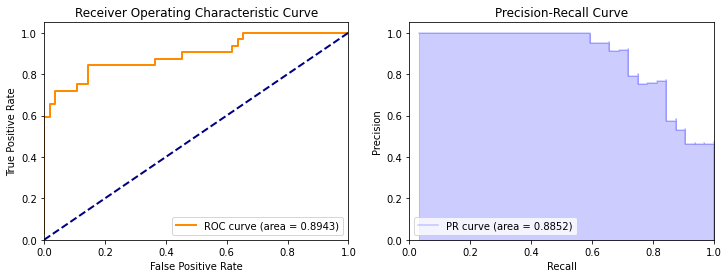

In [ ]:
from handyspark import *
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions_rf, scoreCol='probability', labelCol='label')
# Get metrics from evaluator
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))
# Plot both ROC and PR curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=101)
rfModel = rf.fit(train)
predictions_rf=rfModel.transform(test)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Use regular double quotation marks for predictionCol
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction")

# Assuming predictions_rf is your DataFrame containing predictions
evaluated_value = evaluator_rf.evaluate(predictions_rf)
print("Evaluation Result:", evaluated_value)


Evaluation Result: 0.8400286388792135


In [ ]:
# confusion matrix
predictions_rf.crosstab('label','prediction').show()

+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  6| 26|
|             0.0| 47|  8|
+----------------+---+---+



/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Area under ROC Curve: 0.8943
Area under PR Curve: 0.8852


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



Out[25]: <AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

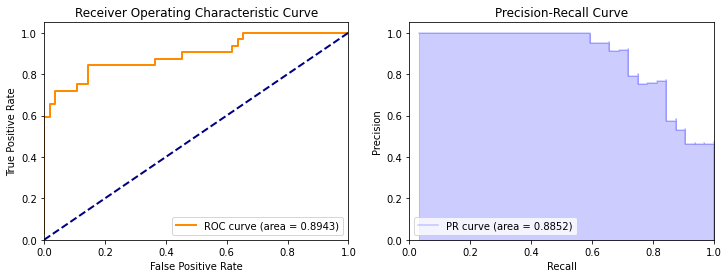

In [ ]:
from handyspark import *
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions_rf, scoreCol='probability', labelCol='label')
# Get metrics from evaluator
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))
# Plot both ROC and PR curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

### Testing Various Thresholds

In [ ]:
from pyspark.sql.types import FloatType
split1_udf = F.udf(lambda value: value[0].item(), FloatType())
split2_udf = F.udf(lambda value: value[1].item(), FloatType())
def test_threshold(model, prob):
    output2 = model.select('rawPrediction','target','probability',split1_udf('probability').alias('class_0'), split2_udf('probability').alias('class_1'))
    from pyspark.sql.functions import col, when
    output2=output2.withColumn('prediction', when(col('class_0')> prob, 1).otherwise(0))
    output2.crosstab('prediction','target').show()

In [ ]:
test_threshold(predictions_rf,.6)

+-----------------+---+---+
|prediction_target|  0|  1|
+-----------------+---+---+
|                0| 27| 14|
|                1|  5| 41|
+-----------------+---+---+



In [ ]:
test_threshold(predictions_rf,.7)

+-----------------+---+---+
|prediction_target|  0|  1|
+-----------------+---+---+
|                0| 28| 20|
|                1|  4| 35|
+-----------------+---+---+



### Feature Importances

Out[29]: Text(0.5, 1.0, 'Feature Importances')

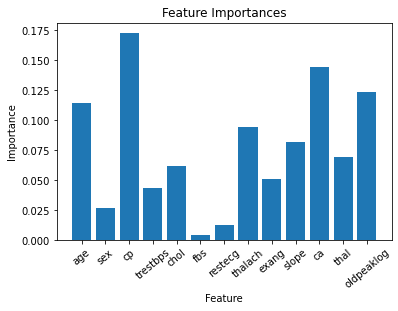

In [ ]:
feat_imps=rfModel.featureImportances
x_values = list(range(len(feat_imps)))
plt.bar(x_values, feat_imps, orientation = 'vertical')
plt.xticks(x_values, ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','slope','ca','thal','oldpeaklog'], rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

### Tune Hyperparameters

In [ ]:
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.arange(200,221,10)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.arange(10,11,10)]) \
    .addGrid(rf.featureSubsetStrategy, [x for x in ["sqrt", "log2", "onethird"]]) \
    .addGrid(rf.impurity, [x for x in ['gini','entropy']]) \
    .addGrid(rf.maxBins, [int(x) for x in np.arange(22, 42, 10)]) \
    .build()
evaluator = BinaryClassificationEvaluator()
rf_crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=evaluator,
                          numFolds=3)
rf_cvModel = rf_crossval.fit(train)
predictions_rf_cv = rf_cvModel.transform(test)

Overall Accuracy of Best CV Model

In [ ]:
evaluator_rf_cv = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator_rf_cv.evaluate(predictions_rf_cv)

Out[31]: 0.8407771696837485

Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0,featuresCol = 'features', labelCol = 'label')
lrModel = lr.fit(train)
predictions_lr = lrModel.transform(test)

In [ ]:
#Overall Accuracy of Model

evaluator_lr = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator_lr.evaluate(predictions_lr)

Out[33]: 0.8731292869223904

In [ ]:
df3.groupby('target','cp').count().show()

+------+---+-----+
|target| cp|count|
+------+---+-----+
|     1|  0|   39|
|     1|  2|   69|
|     1|  1|   41|
|     1|  3|   16|
|     0|  0|  104|
|     0|  1|    9|
|     0|  2|   18|
|     0|  3|    7|
+------+---+-----+



Random Forests is saying that the majority of those who get classified as having Heart Disease have cp=1/atypical angina and cp=2/non-anginal pain, while the majority of those who aren’t classified as having Heart Disease have cp=0/typical angina.

In [ ]:
#thalach: The person’s maximum heart rate achieved

df34=df33.loc[df33['target']==0,'thalach']
df35=df33.loc[df33['target']==1,'thalach']
fig = go.Figure()
fig.add_trace(go.Histogram(x=df34, name='target:0'))
fig.add_trace(go.Histogram(x=df35,name='target:1'))
# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=.9)
fig.update_xaxes(title='Thalach Level')
fig.update_yaxes(dtick=5, range=[0,30], title='Count')
fig.update_layout(title='Comparing Thalach Levels', title_x=0.5)

According to this plot, higher Thalach or maximum heart rate levels are important to a classification of having heart disease, vs. lower levels for being classified as not having heart disease.

ca: The number of major vessels (0–4)

In [ ]:
#ca: The number of major vessels (0–4)

df3.groupby('target','ca').count().show()

+------+---+-----+
|target| ca|count|
+------+---+-----+
|     1|  0|  130|
|     1|  2|    7|
|     1|  1|   21|
|     1|  3|    3|
|     0|  0|   45|
|     1|  4|    4|
|     0|  1|   44|
|     0|  2|   31|
|     0|  3|   17|
|     0|  4|    1|
+------+---+-----+



Random Forests is saying that the majority of those who get classified as having Heart Disease have 0 major vessels, while the majority of those classified as not having Heart Disease have more major vessels, i.e. >0.

The distribution of these variables seems to make intuitive sense. Plus, we were able to infer this from our models!

In [ ]:
predictions_lr.crosstab('label','prediction').show()

+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  6| 26|
|             0.0| 50|  5|
+----------------+---+---+



In [ ]:
#Print Coefficients and Intercept for Logistic Regression

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.008926018437789462,0.5083953455451367,-0.25023004393851317,0.0034372793043313072,0.001082062241049159,0.07385310573566987,-0.16142573759824919,-0.008368623552447428,0.5889769712865041,-0.2976143833417101,0.2658791099653223,0.3187691357673936,0.46123805598304063]
Intercept: -0.9987311595929392


### Conclusion
Given the performance metrics and the robustness of hyperparameter tuning, the Logistic Regression  model appears to be slightly better for this particular dataset, primarily due to its superior handling of a diverse set of features and its ability to capture linear relationships better than Random Forest . The effective use of PySpark for managing data workflows, from preprocessing to model evaluation, underscores its strength in big data scenarios, particularly in healthcare settings where data volume and complexity require robust computational tools.